In [1]:
# python version: 3.7.12
# MacOS version: 14.1.1 (23B81)
# using miniforge conda environment

import pandas as pd
from sklearn.preprocessing import (
    StandardScaler,
    Normalizer,
    MinMaxScaler,
    FunctionTransformer,
)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml


from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [2]:
test_data = pd.read_csv("test.csv")
training_data = pd.read_csv("train.csv")
X, y = training_data.drop("Survived", axis=1), training_data["Survived"]




MODELS_PARAM_GRID = {
    DecisionTreeClassifier(): {
        "classifier__max_depth": [None, 10, 20, 30, 40, 50],
        "classifier__min_samples_split": [2, 5, 10],
        "classifier__min_samples_leaf": [1, 2, 4],
    },
    RandomForestClassifier(): {
        "classifier__n_estimators": [50, 100, 200],
        "classifier__max_features": ["sqrt", "log2", None],
        "classifier__max_depth": [10, 20, 30, 40, 50, None],
        "classifier__min_samples_split": [2, 5, 10],
        "classifier__min_samples_leaf": [1, 2, 4],
    },
    SVC(): {
        "classifier__C": [0.1, 1, 10, 100],
        "classifier__gamma": [1, 0.1, 0.01, 0.001],
        "classifier__kernel": ["rbf", "poly", "sigmoid"],
    },
    MLPClassifier(): {
        "classifier__hidden_layer_sizes": [(50,), (100,)],
        "classifier__activation": ["tanh", "relu"],
        "classifier__solver": ["adam"],
        "classifier__alpha": [0.0001, 0.05],
        "classifier__max_iter": [500],
        "classifier__early_stopping": [True],
        "classifier__learning_rate_init": [0.001, 0.01],
    },
    BaggingClassifier(): {
        "classifier__n_estimators": [10, 50, 100],
        "classifier__max_samples": [0.5, 1.0],
        "classifier__max_features": [0.5, 1.0],
    },
    AdaBoostClassifier(): {
        "classifier__n_estimators": [50, 100, 200],
        "classifier__learning_rate": [0.01, 0.1, 1],
    },
    XGBClassifier(): {
        "classifier__n_estimators": [100, 200, 300],
        "classifier__learning_rate": [0.01, 0.1, 0.2],
        "classifier__max_depth": [3, 4, 5],
    },
    LogisticRegression(): {
        "classifier__C": [0.1, 1, 10, 100],
        "classifier__penalty": ["l1", "l2"],
        "classifier__solver": ["liblinear"],
    },
}

In [3]:
class BatchProcessModel:
    def __init__(self, X, y, data_preprocessing_strategy="standardize"):
        numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
        categorical_features = X.select_dtypes(include=["object"]).columns
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=0
        )

        std_numeric_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]
        )
        norm_numeric_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", Normalizer()),
            ]
        )
        min_max_numeric_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", MinMaxScaler()),
            ]
        )

        available_numeric_transformers = {
            "standardize": std_numeric_transformer,
            "normalize": norm_numeric_transformer,
            "min_max": min_max_numeric_transformer,
        }

        self.numeric_transformer = available_numeric_transformers[
            data_preprocessing_strategy
        ]
        self.categorical_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
                ("onehot", OneHotEncoder(handle_unknown="ignore")),
            ]
        )
        self.preprocessor = ColumnTransformer(
            transformers=[
                ("num", self.numeric_transformer, numeric_features),
                ("cat", self.categorical_transformer, categorical_features),
            ]
        )

        self.results = {}

    def gen_results(self):
        for model, param_grid in MODELS_PARAM_GRID.items():
            pipeline = Pipeline(
                [("preprocessor", self.preprocessor), ("classifier", model)]
            )
            grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
            grid_search.fit(self.X_train, self.y_train)
            best_model = grid_search.best_estimator_
            predictions = best_model.predict(self.X_test)
            accuracy = accuracy_score(self.y_test, predictions)

            self.results[type(model).__name__] = {
                "best_parameters": grid_search.best_params_,
                "accuracy": accuracy,
            }

    def plot_results(self):
        model_names = list(self.results.keys())
        accuracies = [self.results[model]["accuracy"] for model in model_names]

        plt.figure(figsize=(10, 6))
        plt.bar(model_names, accuracies, color="skyblue")
        plt.xlabel("Model")
        plt.ylabel("Accuracy")
        plt.title("Model Comparison - Accuracy")
        plt.xticks(rotation=45)
        plt.ylim([0.7, 0.9])
        plt.grid(axis="y", linestyle="--", alpha=0.7)

        plt.show()




Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


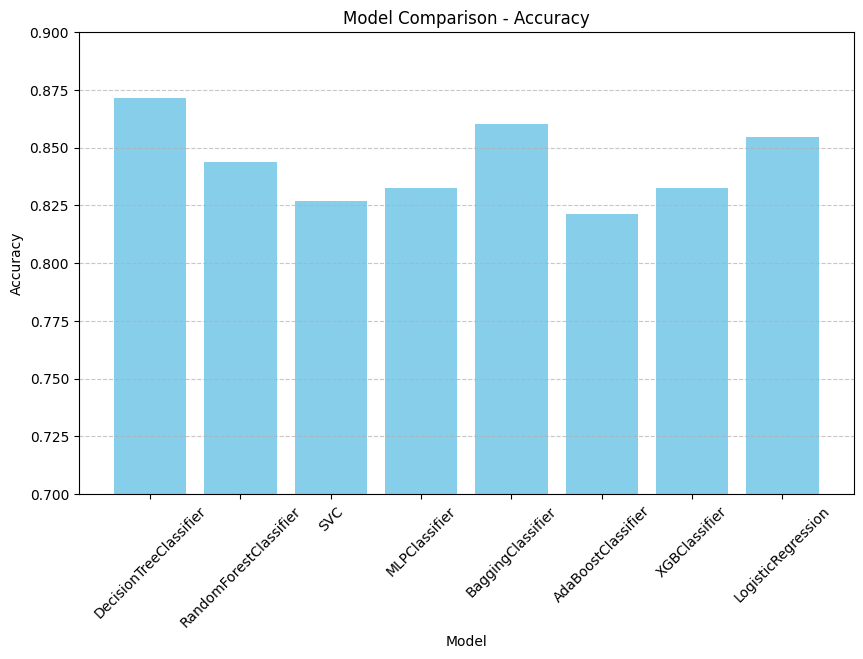

In [4]:
batch_preprocessor = BatchProcessModel(X, y)
batch_preprocessor.gen_results()
batch_preprocessor.plot_results()